# CSPB 3022 - Final Project - Fake News Classification
### By: Grant Fairbairn
### https://github.com/grfa5712/CSPB3022_Fake-News-Classification



In [1]:
# Importing the various libraries and modules used in the project
# To run the code below, may need to install modules. I needed to pip install each of nltk, wordcloud, and textstat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import collections
from collections import defaultdict
from collections import Counter
from textstat import flesch_reading_ease
from textstat import flesch_kincaid_grade

## *Project Topic and Goal*

The phrase "fake news" refers to news articles that are intentionally and verifiably false.$^{[1]}$ Fake news articles have become ubiquitous in American politics and culture in the last 10 years. It is tempting to believe it is a new phenomon, unique to our times. But fake news has a long and sometimes brutal history. $^{[2,3,4]}$ We can document examples as far back as 15th century Italy.$^{[4]}$

What's changed is the speed at which fake news now spreads via the Internet. Social media platforms are particularly problematic, as people can curate a list of likeminded "friends" and create a form of echo chamber where rumors and otherwise laughably false information is repeated until it is accepted as fact.

My goal with this project was to use classification techniques on two datasets containing fake and real news entries to train models to predict whether an article presented fake or real news.

## *Data Source and Description*

The data for this report was found on [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv). I was looking for something timely, and with the onslaught of political news swirling around social media platforms due to the mid-term elections in November 2022, this data set jumped out.  

The data is contained in two files (Fake.csv and True.csv) containing tabulated data. According to the authors, the dataset was collected from real world sources: "the truthful articles were obtained by crawling articles from Reuters.com (News website). As for the fake news articles, they were collected from different sources. The fake news articles were collected from unreliable websites that were flagged by Politifact (a fact-checking organization in the USA) and Wikipedia. The dataset contains different types of articles on different topics, however, the majority of articles focus on political and World news topics."$^{[5,6,7]}$

The True.csv dataset is 53.58 MB and consists of four columns, entitled "title", "text", "subject", and "date". It has 21417 rows of data plus the heading. The "title" column provides the article's title. The "text" column provides the article's text. The "subject" column provides the article's subject. And the "date" column provides the date on which the article was posted. The "title", "text", and "subject" columns contain strings. The "date" column is a DateTime datatype and includes entries from 2016 and 2017. 

The Fake.csv dataset is a little larger, at 63.79 MB. It has the same four column names as the True.csv dataset and 23502 rows. This is close to the same size as the True.csv dataset. Unlike the True.csv dataset, however, the "date" column in the Fake.csv dataset includes entries from 2015 and 2018, along with 2016 and 2017. The difference in date ranges could have presented a problem. But as described below in the *Data Cleaning* section, the dates were not useful to the classification models and were thus omitted.  

In [84]:
news_true = pd.read_csv('True.csv')

display(news_true)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [3]:
news_fake = pd.read_csv('Fake.csv')

display(news_fake)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


## *Data Cleaning*

This was a classification problem, so I first added a column called "True" to both datasets and gave the articles imported from the True.csv dataset a value of $1$ for true and the articles imported from the Fake.csv dataset a value of $0$ for fake.

In [4]:
news_true['True'] = 1
display(news_true)

,title,text,subject,date,True
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [5]:
news_fake['True'] = 0
display(news_fake)

,title,text,subject,date,True
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


I then merged the two dataframes. The new "news_merge" dataframe contained 44898 rows:

In [6]:
news_merge = pd.concat([news_true, news_fake], axis = 0)
news_merge.rename(columns={'title': 'Title', 'text': 'Text', 'subject': 'Subject', 'date': 'Date'}, inplace=True)
news_merge.reset_index(drop=True, inplace=True)
display(news_merge)

,Title,Text,Subject,Date,True
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


Having created a merged set, I decided to check for balance in the "True" column to make sure I had a good set to use for classification. In the bar plot below, we can see that the classification is binonimal with true having a value of 1 and fake having a value of 0. The set is pretty evenly balanced, which is good for classification and machine learning:

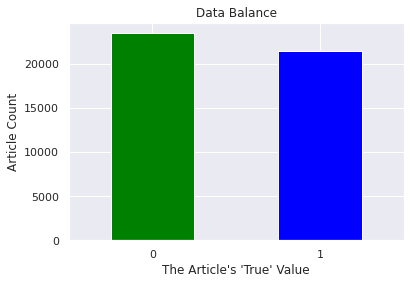

In [7]:
news_merge['True'].value_counts().plot(kind='bar', color=['green', 'blue'], rot=0)
plt.xlabel("The Article's 'True' Value")
plt.ylabel("Article Count")
plt.title("Data Balance")
plt.show()

Next, I made sure to deal with any potential missing or NaN values in the merged dataset. I first checked to see if any appeared using the 'isnull' function. My check returned none, so it appeared that the dataset was pretty clean to start:

In [8]:
news_merge.isnull().sum()

Title      0
Text       0
Subject    0
Date       0
True       0
dtype: int64

Indeed, I could can see that when I used the 'drop NA' function, no rows are dropped and the dataframe continued to have 44898 rows:

In [9]:
news_merge.dropna(inplace=True)
display(news_merge)

,Title,Text,Subject,Date,True
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


I then used some visualization tools to look for features that I could omit from the analysis because they would not be relevant to the classification problem. 

While I initially expected the "Subject" column to be valuable as a feature to include in the models, the visualizations quickly dispelled that notion. 

From reading the background materials regarding the dataset, it appears that the strings within the "Subject" column (*e.g.*, "politicsNews" and "Government News") were created and populated by the dataset's creators, not the authors of the articles themselves. Conversely, each article's text was left as is, with typos included, as those are potential signs of a fake article that could be used in the classification process.$^{[6,7,8]}$ As the bargraph below shows, all articles identified as pertaining to the "politicsNews" and "worldnews" subjects came from the True.csv set, while the rest of the subjects came from the Fake.csv set.

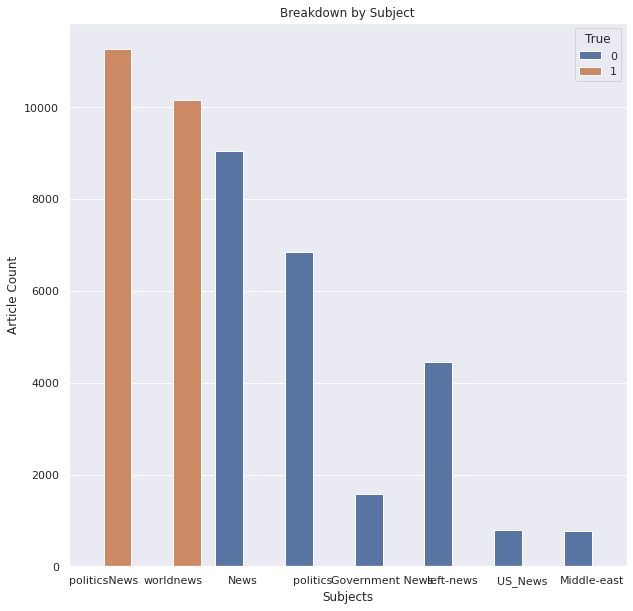

In [10]:
plt.figure(figsize=(10,10))
sns.countplot(x='Subject', data=news_merge, hue='True')
plt.ylabel("Article Count")
plt.xlabel("Subjects")
plt.title("Breakdown by Subject")
plt.show()

This presented a potential problem for my prediction models. Using the "Subject" column in the models could cause the models' predictions to be artificially accurate because the models could use the "Subject" categories instead of the content of the "Title" or "Text" columns to generate predictions. Given the clear divide in the "Subject" column, it would be far too easy to classify articles in the set as $1$ or $0$ using just the strings in "Subject". As a result, I chose to drop the "Subject" column from the dataframe.

In [11]:
news_merge.drop('Subject', inplace=True, axis=1)
display(news_merge)

,Title,Text,Date,True
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,"December 29, 2017",1
...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,"January 14, 2016",0


I next looked at the "Date" column. That data could be a bit tricky because the date ranges differ between the Fake.csv and True.csv files. But as with the "Subject" column, the "Date" column is not necessary for the analysis. The date ranges in the two sets are similar (2015-2018 for Fake.csv and 2016-2017 for Real.csv), but the dates themselves do not help classify the articles into "Fake" versus "True" categories. Thus, I dropped the "Date" column as well.


In [12]:
news_merge.drop('Date', inplace=True, axis=1)
display(news_merge)

,Title,Text,True
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


Finally, I shuffled the rows in the news_merge dataframe so that they were no longer all true in the first half and all false in the second half.

In [13]:
news_merge = news_merge.sample(frac=1)
display(news_merge)

,Title,Text,True
6029,Speaker Ryan says 'black sites' document not f...,(Reuters) - U.S. House of Representatives Spea...,1
21987,Fox News Asks This Man For Pictures Of New Yo...,"Today, there were hundreds of marches showing ...",0
30970,HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issu...,Was the first actress who outed accused rapist...,0
28662,Florida Continues For-Profit Juvenile Prisons...,The Florida Department of Juvenile Justice has...,0
17722,Brazil's president treated for small coronary ...,BRASILIA (Reuters) - Brazilian President Miche...,1
...,...,...,...
42864,HERE’S THE LIST Of Heartless Senators Who Vote...,Godless heartless and without conscience .Sena...,0
18382,Trump says Puerto Rico's debt will have to be ...,(Reuters) - President Donald Trump said on Tue...,1
29871,Video Of Man Casually Doing Interview After J...,"A Quincy, Il, man was shot in the hourly hours...",0
19512,China top graft buster says corruption fight '...,BEIJING (Reuters) - Fixing the corruption prob...,1


With the dataset cleaned and irrelevant features removed, I proceeded into exploratory data analysis.

## *Exploratory Data Analysis*

One of the most difficult aspects of this project was that the data was in text form instead of the numeric. I was far more comfortable working with quantitative data coming in. This meant that I needed to learn how to do some text statistic visualizations, which I had no experience with before this project.

My initial plan was to combine the contents of the "Title" and "Text" columns to get down to one feature to use in the prediction models. Early on, I spotted a potential "cheat" in the text that would make classification prediction much easier. As shown below, the word "Reuters" appears in the "Text" column for many of the true articles but few of the fake ones: 

In [14]:
display(news_merge)

,Title,Text,True
6029,Speaker Ryan says 'black sites' document not f...,(Reuters) - U.S. House of Representatives Spea...,1
21987,Fox News Asks This Man For Pictures Of New Yo...,"Today, there were hundreds of marches showing ...",0
30970,HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issu...,Was the first actress who outed accused rapist...,0
28662,Florida Continues For-Profit Juvenile Prisons...,The Florida Department of Juvenile Justice has...,0
17722,Brazil's president treated for small coronary ...,BRASILIA (Reuters) - Brazilian President Miche...,1
...,...,...,...
42864,HERE’S THE LIST Of Heartless Senators Who Vote...,Godless heartless and without conscience .Sena...,0
18382,Trump says Puerto Rico's debt will have to be ...,(Reuters) - President Donald Trump said on Tue...,1
29871,Video Of Man Casually Doing Interview After J...,"A Quincy, Il, man was shot in the hourly hours...",0
19512,China top graft buster says corruption fight '...,BEIJING (Reuters) - Fixing the corruption prob...,1


This was not an accident; the creators of the dataset indicated in their README file that they sourced their true articles from Reuters and fake articles from a variety of other sources.$^{[5]}$ 

While that decision makes sense in terms of building a true versus fake article dataset, it means that the set is unbalanced when the word "Reuters" is included. If the prediction models picked up on that distinction, it could make the prediction task trivially easy. 

This concern is reflected in the data, as the word "Reuters" appears in 21378 of the 21417 rows in the True.csv dataset (but only 322 rows out of 23481 in the Fake.csv dataset).

In [15]:
reuters_true = news_true.loc[news_true['text'].str.contains("Reuters", case=False)]
print('The word Reuters appears in', len(reuters_true), 'of the', len(news_true), 'rows in the True.csv dataset (i.e.,', round(100*(len(reuters_true)/len(news_true)), 2),'% of the articles).') 
reuters_fake = news_fake.loc[news_fake['text'].str.contains("Reuters", case=False)]
print('The word Reuters appears in', len(reuters_fake), 'of the', len(news_fake), 'rows in the Fake.csv dataset (i.e.,', round(100*(len(reuters_fake)/len(news_fake)), 2),'% of the articles).') 
reuters_merge = pd.concat([reuters_true, reuters_fake], axis = 0)
reuters_merge.reset_index(drop=True, inplace=True)

The word Reuters appears in 21378 of the 21417 rows in the True.csv dataset (i.e., 99.82 % of the articles).
The word Reuters appears in 322 of the 23481 rows in the Fake.csv dataset (i.e., 1.37 % of the articles).


We can visualize this imbalance by plotting the number of true articles that contain the word "Reuters" versus the number of fake articles that do so:

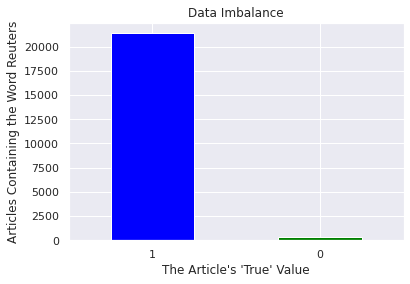

In [16]:
reuters_merge['True'].value_counts().plot(kind='bar', color=['blue', 'green'], rot=0)
plt.xlabel("The Article's 'True' Value")
plt.ylabel("Articles Containing the Word Reuters")
plt.title("Data Imbalance")
plt.show()

That initially seemed like a major problem that would require more data cleaning before I could convert the text into numerical values and feed it into my models. I assumed that I would need to find a way to alter the "Text" column to remove references to "Reuters" and make the classification problem more difficult for the models.

Thankfully, I did not jump right to that step. I first decided to create some histograms showing the characteristics of the text in the "Title" and "Text" columns and see if anything else would require attention.

Things started well, as I was able to chart the number of characters in the "Title" and "Text" columns for both true and fake articles. 

As shown below, a few interesting points are revealed by the "Title" histograms. The peak of the histograms for the "Title" character count is pretty similar (around 65-70 for the true articles and 75-80 for the fake articles). But there were differences on the high end. Only a small percentage of articles in the true set had titles longer than about 90 characters and none had more than 120. In the fake set, however, longer titles were common; the 100-character titles were the second highest level in the histogram and there were over 1000 articles with titles containing more than 150 characters. 

That disparity makes some intuitive sense. Professional news writers seem less likely to write overly-long titles on articles.

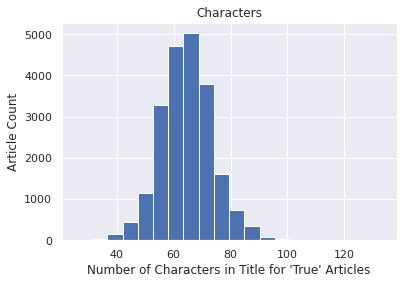

In [17]:
trueset = news_merge.loc[news_merge['True'] == 1]
trueset['Title'].str.len().hist(bins=20);
plt.xlabel("Number of Characters in Title for 'True' Articles")
plt.ylabel("Article Count")
plt.title("Characters")
plt.show()

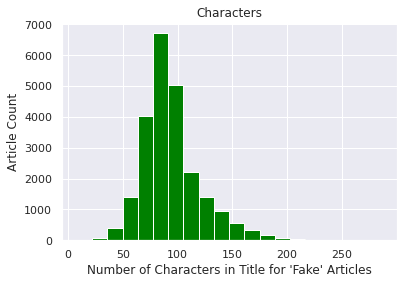

In [18]:
fakeset = news_merge.loc[news_merge['True'] == 0]
fakeset['Title'].str.len().hist(bins=20, color='green');
plt.xlabel("Number of Characters in Title for 'Fake' Articles")
plt.ylabel("Article Count")
plt.title("Characters")
plt.show()

The histograms for character counts in the "Text" column likewise reflected subtle differences. The peaks were very similar, but the fake data plot showed articles with more than 10,000 characters, while the true articles each had 10,000 characters or less. In other words, there were differences between true and fake articles in the higher values of character counts. It was more difficult to differentiate between true and fake in the lower character counts.

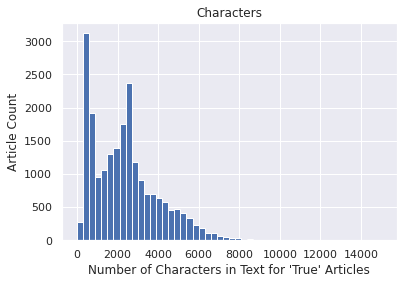

In [19]:
trueset['Text'].str.len().hist(range=[0,15000], bins=50);
plt.xlabel("Number of Characters in Text for 'True' Articles")
plt.ylabel("Article Count")
plt.title("Characters")
plt.show()

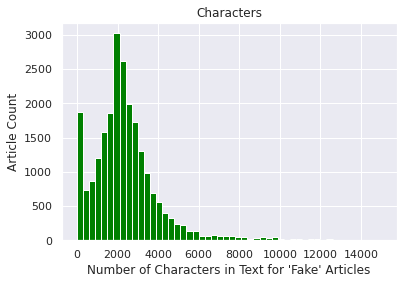

In [20]:
fakeset['Text'].str.len().hist(range=[0,15000],bins=50, color='green');
plt.xlabel("Number of Characters in Text for 'Fake' Articles")
plt.ylabel("Article Count")
plt.title("Characters")
plt.show()

Next, I sought to compare the number of words in titles and text. I was able to use the split function on the "Title" column and count the words in the true and false article titles:

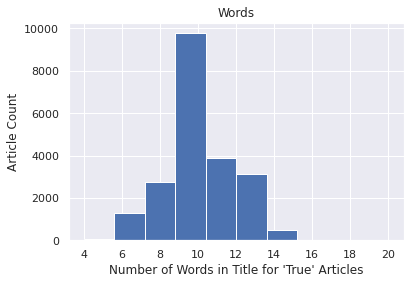

In [21]:
trueset['Title'].str.split().map(lambda x: len(x)).hist()
plt.xlabel("Number of Words in Title for 'True' Articles")
plt.ylabel("Article Count")
plt.title("Words")
plt.show()

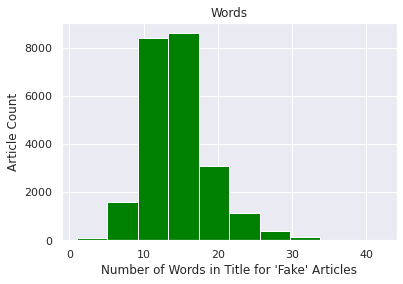

In [22]:
fakeset['Title'].str.split().map(lambda x: len(x)).hist(color='green')
plt.xlabel("Number of Words in Title for 'Fake' Articles")
plt.ylabel("Article Count")
plt.title("Words")
plt.show()

In keeping with the character-count analysis, the word counts for the fake article titles were generally a little higher than the true article titles. The peak for the true articles was around 10 words per title, whereas the fake articles peaked at around 15. 

But the word-count test revealed a problem that ultimately changed my plans for what inputs I would include in my models. When I tried to use the split function on the 'Text' column, my Python kernel repeatedly crashed. Processing that much text consistently exceeded the alloted memory in Python. I never was able to get the code to work with the "Text" column and eventually had to move on with just the "Title" column. 

That changed the project a bit, because now I was testing models with just "Title". My plan if the models performed poorly was to return to the "Text" column and figure out a way to adjust the data so as to avoid the memory issue. Thankfully, that ended up not being an issue, as discussed below in the Results section.

In [23]:
# Here is the offending code. I never could get it to run to completion without the kernel crashing

#trueset_split = trueset['Text'].str.split().map(lambda x: len(x))
#plt.xlabel("Number of Words in Text for 'True' Articles")
#plt.ylabel("Article Count")
#plt.title("Words")
#plt.show()

With my analysis focusing in on the "Title" column, I set out to use some of the Python tools for natural language processing (NLP) taught in the excellent online tutorial "Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools".$^{[8]}$ I had exactly zero experience with any of these tools coming in, so the tutorial was a great resource!

Using an algorithm described in the NLP tutorial, I was able to separate out "stopwords" (*i.e.*, words that are most common in the English language like "the", "and", and "to") in the 'Title' column to see if there were any differences between true and fake articles.

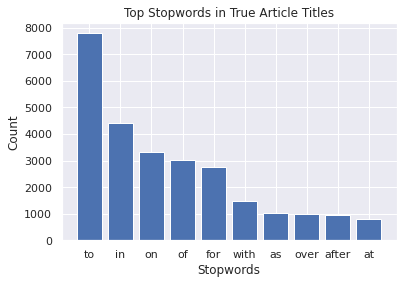

In [24]:
stop = set(stopwords.words('english'))
    
new = trueset['Title'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
dictionary = defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary[word]+=1
            
top=sorted(dictionary.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)
plt.xlabel("Stopwords")
plt.ylabel("Count")
plt.title("Top Stopwords in True Article Titles")
plt.show()

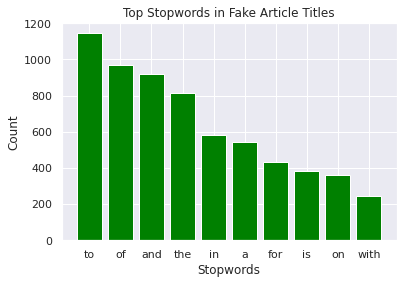

In [25]:
new = fakeset['Title'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
dictionary = defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary[word]+=1
            
top=sorted(dictionary.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='green')
plt.xlabel("Stopwords")
plt.ylabel("Count")
plt.title("Top Stopwords in Fake Article Titles")
plt.show()

These graphs surprised me. The words that rose to the top in each set were similar, but the counts were significantly different. The top stopword in both sets (*i.e.*, "to") appeared almost 8,000 times in the true article titles but only around 1,200 in the fake article titles (an almost 7x difference). At that point, I wasn't exactly sure why that would be the case.

I got my answer, however, when I applied a similar approach from the tutorial for counting *non-stopwords* in the titles:

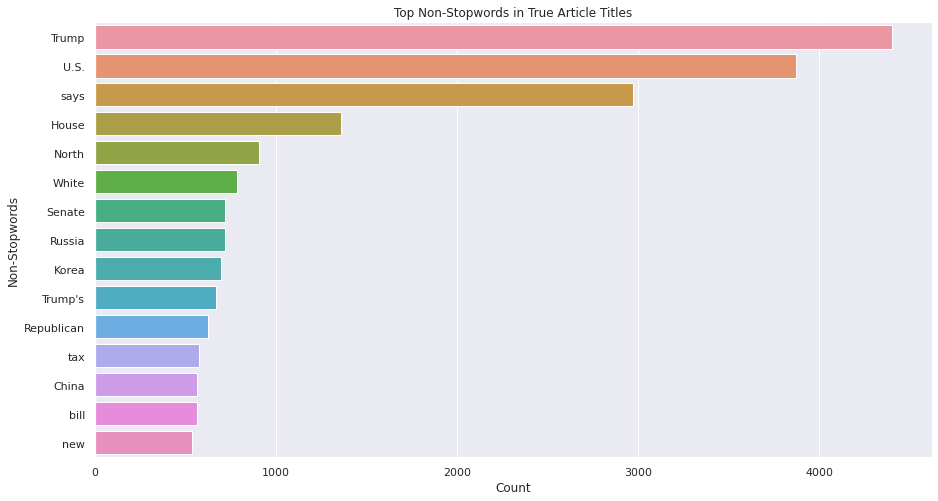

In [26]:
new = trueset['Title'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:30]:
    if (word not in stop):
        x.append(word)
        y.append(count)
    
plt.figure(figsize=(15,8))
plt.xlabel("Count")
plt.ylabel("Non-Stopwords")
plt.title("Top Non-Stopwords in True Article Titles")
sns.barplot(x=y,y=x);

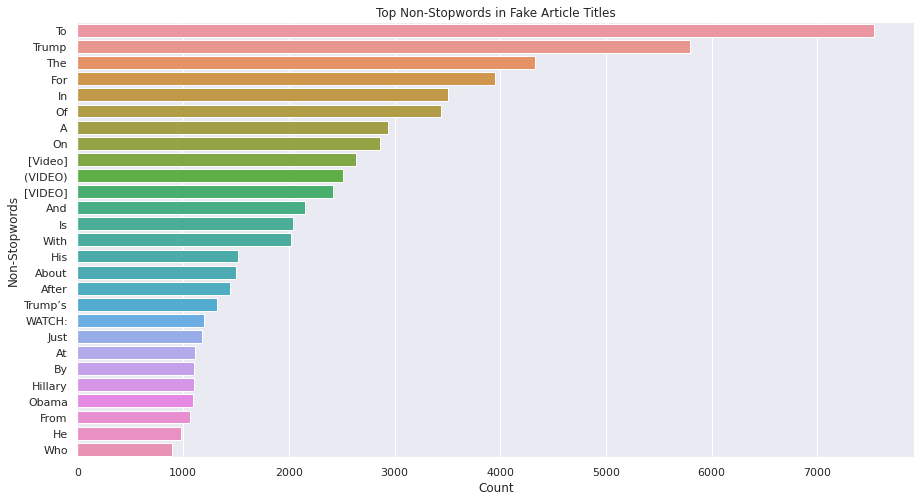

In [27]:
new = fakeset['Title'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:30]:
    if (word not in stop):
        x.append(word)
        y.append(count)
    
plt.figure(figsize=(15,8))
plt.xlabel("Count")
plt.ylabel("Non-Stopwords")
plt.title("Top Non-Stopwords in Fake Article Titles")
sns.barplot(x=y,y=x);

There it was! The word "To" showed up in fake article titles over 7,000 times. Three of the top five "non-stopword" entries in the titles to the fake articles are "To", "For", and "In". When spelled with a lower-case first letter, those stopwords would have been screened off as stopwords and included in the prior set of graphs. That helps explain why the stopword count for those words was so much lower for the fake article titles than the true article titles. By capitalizing the first letter of many short stopwords, the authors of the fake articles may have inadvertantly left a clue as to whether the article was fake.

To further visualize the difference in common words, I decided to try the wordcloud example in the NLP tutorial mentioned above.$^{[8]}$ This was my first exposure to built-in tools like PorterStemmer and WordNetLemmatizer that reduce words to their word stems. And it was my first time ever creating a wordcloud.

Following the model in the tutorial, I was able to generate two wordclouds. They again showed the prevalence of stopwords with a capitalized first letter in the fake article titles but not in the true article titles.

In [28]:
# Helper function from NLP tutorial for creating a wordcloud from a text column in Pandas dataframe

def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.title("Wordcloud for Article Titles")
    plt.show()

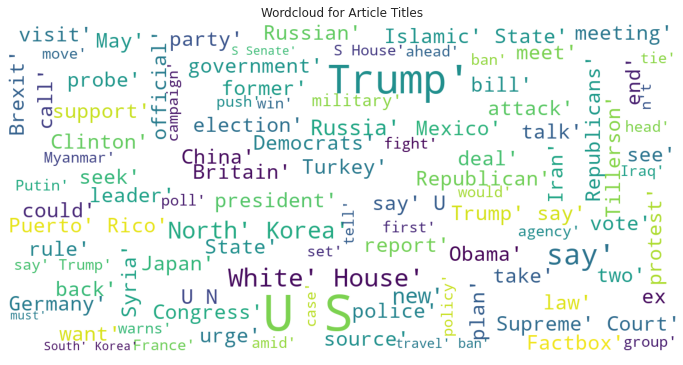

In [29]:
# Applying the helper function to the true article titles

plot_wordcloud(trueset['Title'])

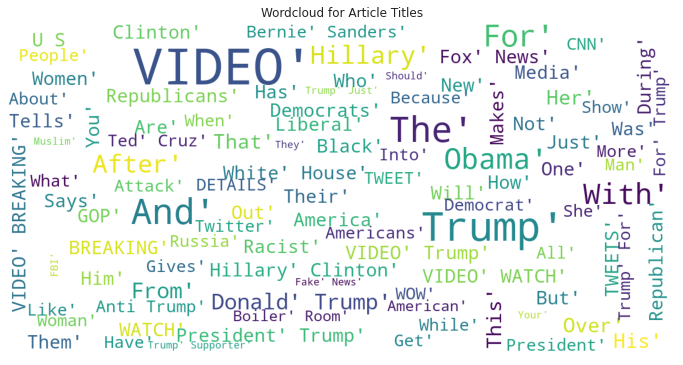

In [30]:
# Applying the helper function to the fake article titles

plot_wordcloud(fakeset['Title'])

While there is some overlap in the two wordclouds (particularly with the names of famous political figures), the fake article wordcloud contained common stopwords with the first letter capitalized like "The", "And", and "For". It also contained the words "Video" and "VIDEO", which are completely absent from the true article wordcloud.

If I had more time, I would try to figure out how to remove the trailing apostrophe that appears after each word in the wordclouds. I tried a few fixes but ended up going backwards. Eventually, I had to move on!

While I had a good amount of information from my EDA efforts by this point, and had started to focus in on leaving in/removing stopwords as a potential parameter adjustment to my models, I also tried comparing reading ease. I plotted the titles' Flesch Reading Ease (FRE) - in which a higher score represents text that is easier to read - and Flesch Kincaid Grade Level (FKGL) - which provides a number corresponding with a grade level for a US student. 

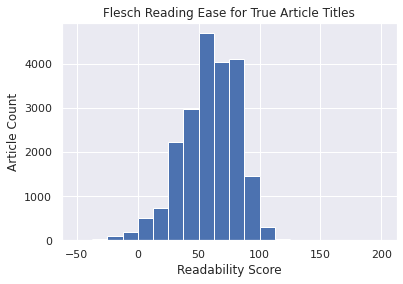

In [31]:
trueset['Title'].apply(lambda text : flesch_reading_ease(text)).hist(bins=20, range=[-50,200]);
plt.xlabel("Readability Score")
plt.ylabel("Article Count")
plt.title("Flesch Reading Ease for True Article Titles")
plt.show()

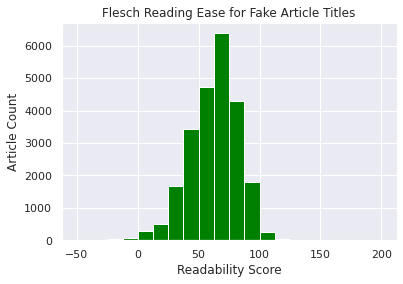

In [32]:
fakeset['Title'].apply(lambda text : flesch_reading_ease(text)).hist(bins=20, range=[-50,200], color='green');
plt.xlabel("Readability Score")
plt.ylabel("Article Count")
plt.title("Flesch Reading Ease for Fake Article Titles")
plt.show()

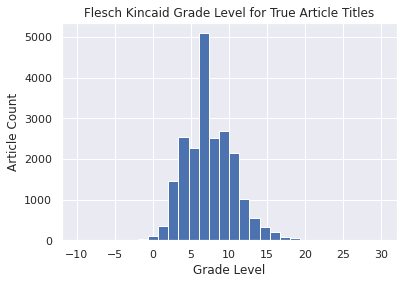

In [33]:
trueset['Title'].apply(lambda text : flesch_kincaid_grade(text)).hist(bins=30, range=[-10,30]);
plt.xlabel("Grade Level")
plt.ylabel("Article Count")
plt.title("Flesch Kincaid Grade Level for True Article Titles")
plt.show()

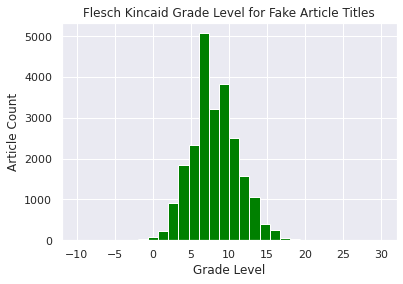

In [34]:
fakeset['Title'].apply(lambda text : flesch_kincaid_grade(text)).hist(bins=30, range=[-10,30], color='green');
plt.xlabel("Grade Level")
plt.ylabel("Article Count")
plt.title("Flesch Kincaid Grade Level for Fake Article Titles")
plt.show()

While these charts were fun to prepare and kind of interesting in their own right, there were not really any discernable differences between fake and true article titles when it comes to readability. The titles for both true and fake articles received about the same scores.

By the time I was done with my EDA, the stopwords issue had emerged as the biggest differentiator, and it influenced how I built the models in the next section.

Finally, for one last sanity check, I tried again to utilize the "Text" column to look at stopwords and build wordclouds. The Python kernel crashed each time. I thus decided to drop the "Text" column. That resolved the "Reuters" problem, as that word was used in the "Text" and not the "Title" column.

Going into the modeling phase, that meant the dataframe looked like this:

In [35]:
news_merge.drop('Text', inplace=True, axis=1)
display(news_merge)

,Title,True
6029,Speaker Ryan says 'black sites' document not f...,1
21987,Fox News Asks This Man For Pictures Of New Yo...,0
30970,HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issu...,0
28662,Florida Continues For-Profit Juvenile Prisons...,0
17722,Brazil's president treated for small coronary ...,1
...,...,...
42864,HERE’S THE LIST Of Heartless Senators Who Vote...,0
18382,Trump says Puerto Rico's debt will have to be ...,1
29871,Video Of Man Casually Doing Interview After J...,0
19512,China top graft buster says corruption fight '...,1


## *Models*

Coming into the modeling step, I wanted to try a few different classification models and compare their results to decide which provided the best fit. I initially planned to try simple logistic regression and a more difficult Naive Bayes classifier. I also decided to try using Support Vector Classifiers (SVC), a class of Support Vector Machines (SVMs).$^{[9]}$ 

In order to build and fit the models, I planned to split the news_merge dataframe into random train and test subsets using the sklearn train_test_split function. 

Unfortunately, I could not just feed the text from the "Title" column into the classification models. I needed to first figure out how to convert the text in the "Title" column into numerical values that the models could understand and apply. To do this, I eventually settled on using the TF-IDF Vectorizer (TfidfVectorizer) module from sklearn. TF-IDF stands for Term Frequency Inverse Document Frequency and it is a common algorithm used to transform text into a numerical representation that can be used for in a prediction model.$^{[10]}$

First, I converted the text and values contained in the "Title" and "True" columns into numpy arrays to be used with the TfidfVectorizer and sklearn train_test_split function by using the to_numpy function:

In [36]:
X = news_merge['Title'].to_numpy()
y = news_merge['True'].to_numpy()

print(X)
print(y)

["Speaker Ryan says 'black sites' document not from Trump"
 ' Fox News Asks This Man For Pictures Of New York Solidarity March – His Response Is PRICELESS'
 'HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issued For Her Arrest…Coincidence?'
 ...
 ' Video Of Man Casually Doing Interview After Just Being Shot Goes Viral (VIDEO)'
 "China top graft buster says corruption fight 'world class hard'"
 'Exposing the Shakespearean tragedy of the “Russia Hacking” hoax']
[1 0 0 ... 0 1 0]


With the text now stored in the "X" array and the corresponding categorical "y" array set up, I was almost ready to use the train_test_split function. But first I needed to use the TfidfVectorizer function to convert the text to numerical values:

In [37]:
# Instantiating the vectorizer object
vect = TfidfVectorizer()

# Fitting the text using the vectorizer object
vect.fit(X)

# Transforming the text to numerical form
X = vect.transform(X)

# Displaying completed conversion
print(X)

  (0, 19217)	0.12629550458995784
  (0, 17458)	0.3737267737250784
  (0, 17038)	0.5036781857887201
  (0, 16273)	0.20901233172766617
  (0, 16087)	0.3479226914095578
  (0, 12744)	0.24798405166471263
  (0, 7868)	0.243088770686319
  (0, 5886)	0.4679044340454153
  (0, 2279)	0.2939844818300721
  (1, 20805)	0.2706980462927686
  (1, 18721)	0.1921107210522388
  (1, 17346)	0.40734413998982116
  (1, 15570)	0.25679898858430666
  (1, 14330)	0.3220462588686876
  (1, 13814)	0.36192717532479096
  (1, 12932)	0.11889416264842967
  (1, 12612)	0.20760810161359217
  (1, 12603)	0.18157749260136505
  (1, 11514)	0.2868992796800327
  (1, 11436)	0.2352704917038849
  (1, 10061)	0.1569974301729656
  (1, 9079)	0.18131015097619183
  (1, 7761)	0.23613364547025775
  (1, 7663)	0.12094994635809432
  (1, 1427)	0.2597223749868206
  :	:
  (44895, 10355)	0.20485587254496457
  (44895, 9948)	0.285023415069031
  (44895, 8274)	0.26461524894365374
  (44895, 5912)	0.3288764463271663
  (44895, 3231)	0.506993182135774
  (44895, 2068

After using the TF-IDF vectorizer on "X", both the "X" and "y" arrays were in numerical form and ready to be separated into train and test sets to develop the models. I chose to set the test size at 20% and use the other 80% for training the models:

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

First up was logistic regression. I named this model "logistic1" because I eventually decided to create a second logistic regression model ("logistic2") after removing stopwords from the "Title" column.

In [39]:
logistic1 = LogisticRegression()
logistic1.fit(X_train, y_train)

LogisticRegression()

In [40]:
logistic1_y_pred = logistic1.predict(X_test)

One of the main benefits to using logistic regression here was that the model trained very quickly (around 4 seconds). The same would not be true for SVC below. With the predictions stored in the logistic1_y_pred variable, I moved on to build my first SVC model ("SVC1"). I ended up building a second SVC model ("SVC2") as well, after removing stopwords from the "Title" column.

In [41]:
clf1 = SVC(random_state=0)
clf1.fit(X_train, y_train)

SVC(random_state=0)

In [42]:
SVC1_y_pred = clf1.predict(X_test)

Unlike the logistic regression model, the SVC model was *slow* and took a long time to fit the data. On average, it took over 4 minutes for the clf.fit(X_train, y_train) line to execute. That makes some sense, as SVMs are used and effective in high-dimensional spaces. I was interested to see if that difference in training time would pay off in a more accurate model than the much faster logistic regression model.

My attempt at a third model (Naive Bayes classifier) went down in flames. I was interested in Naive Bayes because I had read that it was useful in detecting the differences between "spam" and "ham" emails.$^{[11]}$ That sounded similar to my problem, so I tried to teach myself how to use the model. I had not worked with them in class, but there were a number of tutorials available online.

Unfortunately, I could not get it to work. I tried several tutorials but simply could not build a model without receiving error messages. After much frustration and many hours, I had to abandon the model and continue on with linear regression and SVC.

What I decided to do instead was engage in some feature engineering so that I would have a before-and-after comparison. Having already built and saved predictions for logistic regression and SVC using the unaltered "Title" column, I knew how those models performed (see below in Results and Analysis). I decided to test my hypothesis from EDA that the capitalized stopwords in the fake article titles could affect a model by building a second round of models with stopwords removed from the "Title" feature.

In [50]:
# Before removing stopwords
display(news_merge)

,Title,True
6029,Speaker Ryan says 'black sites' document not f...,1
21987,Fox News Asks This Man For Pictures Of New Yo...,0
30970,HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issu...,0
28662,Florida Continues For-Profit Juvenile Prisons...,0
17722,Brazil's president treated for small coronary ...,1
...,...,...
42864,HERE’S THE LIST Of Heartless Senators Who Vote...,0
18382,Trump says Puerto Rico's debt will have to be ...,1
29871,Video Of Man Casually Doing Interview After J...,0
19512,China top graft buster says corruption fight '...,1


In [51]:
# Removing stopwords
news_merge['Title'] = news_merge['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [52]:
# After removing stopwords
display(news_merge)

,Title,True
6029,Speaker Ryan says 'black sites' document Trump,1
21987,Fox News Asks This Man For Pictures Of New Yor...,0
30970,HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issu...,0
28662,Florida Continues For-Profit Juvenile Prisons ...,0
17722,Brazil's president treated small coronary bloc...,1
...,...,...
42864,HERE’S THE LIST Of Heartless Senators Who Vote...,0
18382,Trump says Puerto Rico's debt wiped,1
29871,Video Of Man Casually Doing Interview After Ju...,0
19512,China top graft buster says corruption fight '...,1


With a newly-updated feature, I ran through the same steps as above for converting the text into numerical form and creating train and test sets:

In [53]:
X = news_merge['Title'].to_numpy()
y = news_merge['True'].to_numpy()

print(X)
print(y)

["Speaker Ryan says 'black sites' document Trump"
 'Fox News Asks This Man For Pictures Of New York Solidarity March – His Response Is PRICELESS'
 'HARVEY WEINSTEIN RAPE ACCUSER Has Warrant Issued For Her Arrest…Coincidence?'
 ...
 'Video Of Man Casually Doing Interview After Just Being Shot Goes Viral (VIDEO)'
 "China top graft buster says corruption fight 'world class hard'"
 'Exposing Shakespearean tragedy “Russia Hacking” hoax']
[1 0 0 ... 0 1 0]


In [54]:
vect = TfidfVectorizer()
vect.fit(X)
X = vect.transform(X)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

I then fed the non-stopwords data into the logistic regression and SVC models, saving the predictions as logistic2_y_pred and SVC2_y_pred.

In [56]:
logistic2 = LogisticRegression()
logistic2.fit(X_train, y_train)

LogisticRegression()

In [57]:
logistic2_y_pred = logistic2.predict(X_test)

In [58]:
clf2 = SVC(random_state=0)
clf2.fit(X_train, y_train)

SVC(random_state=0)

In [59]:
SVC2_y_pred = clf2.predict(X_test)

## *Results and Analysis*

So how did the four models do? Very well, actually!

First up was logistic regression with the stopwords included in the text (*i.e.*, logistic1). Over multiple runs, this model routinely resulted in accuracy of around 95%.

In [60]:
logistic1_accuracy = round(accuracy_score(y_test, logistic1_y_pred), 4)
print(f"The logistic1 regression model (which includes stopwords) had an accuracy of {logistic1_accuracy}")

The logistic1 regression model (which includes stopwords) had an accuracy of 0.9514


Visualizing the results in a confusion matrix, we can see that there were certainly false positives and false negatives, but in small numbers compared with the true positives and true negatives.

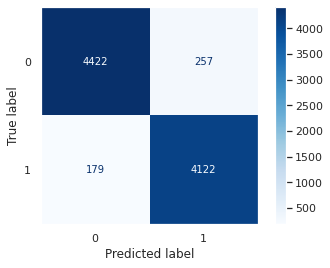

In [62]:
logistic1_cm = confusion_matrix(y_test, logistic1_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=logistic1_cm)
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

From the classification report, we can also see that the precision, recall, and f1-score rates were very high for the 8980 articles tested. This turned out to be a very good model.

In [63]:
logistic1_report = classification_report(y_test, logistic1_y_pred)
print(logistic1_report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4679
           1       0.94      0.96      0.95      4301

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



So how about the SVC1 model, the one with stopwords included? Well that performed even a little better than logistic1. The SVC1 model routinely provided accuracy scores of 96% or 97%.

In [64]:
SVC1_accuracy = round(accuracy_score(y_test, SVC1_y_pred), 4)
print(f"The SVC1 model (which includes stopwords) has an accuracy of {SVC1_accuracy}")

The SVC1 model (which includes stopwords) has an accuracy of 0.9625


The confusion matrix for SVC1 likewise shows a small number of false positives and false negatives compared to the true positives and true negatives.

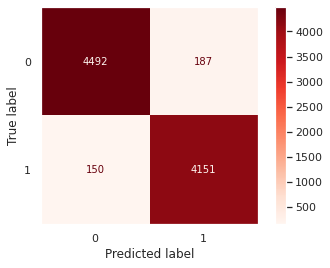

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test, SVC1_y_pred, cmap='Reds')
plt.grid(False)
plt.show()

And the precision, recall, and f1-score results are all excellent for the SVC1 model.

In [66]:
SVC1_report = classification_report(y_test, SVC1_y_pred)
print(SVC1_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4679
           1       0.96      0.97      0.96      4301

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



While the accuracy scores were already very high with stopwords included, I decided to do some feature engineering and see if I could improve performance even a little more by first screening off stopwords. As mentioned in the EDA section, my hypothesis was that excluding stopwords would create an even larger discrepancy between the true and fake article titles that the models might pick up.

The numbers bore that out. Both logistic2 and SVC2 performed incrementally better than logistic1 and SVC1, respectively. 

The logistic2 regression model had accuracy, precision, recall, and f1-scores that were about 2-3% higher than logistic1. And the SVC2 model scored about 2% higher in each of those values than SVC1. On more than one run, SVC2 reached 99% in all four measures.


In [77]:
logistic2_accuracy = round(accuracy_score(y_test, logistic2_y_pred), 4)
print(f"The logistic2 regression model (which excludes stopwords) has an accuracy of {logistic2_accuracy}")

The logistic2 regression model (which excludes stopwords) has an accuracy of 0.9787


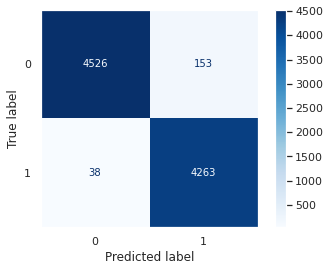

In [78]:
logistic2_cm = confusion_matrix(y_test, logistic2_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=logistic2_cm)
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

In [79]:
logistic2_report = classification_report(y_test, logistic2_y_pred)
print(logistic2_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4679
           1       0.97      0.99      0.98      4301

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [80]:
SVC2_accuracy = round(accuracy_score(y_test, SVC2_y_pred), 4)
print(f"The SVC2 model (which excludes stopwords) has an accuracy of {SVC2_accuracy}")

The SVC2 model (which excludes stopwords) has an accuracy of 0.9873


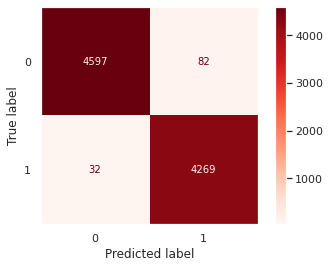

In [81]:
ConfusionMatrixDisplay.from_predictions(y_test, SVC2_y_pred, cmap='Reds')
plt.grid(False)
plt.show()

In [82]:
SVC2_report = classification_report(y_test, SVC2_y_pred)
print(SVC2_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4679
           1       0.98      0.99      0.99      4301

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## *Discussion and Conclusion*

This project was both fun and humbling. It was fun mostly because it worked, and I ended up with multiple models scoring above 95% on the prediction task. One of my models (SVC2) scored 99% in the four measures that I was tracking. I also learned how to use several new libraries and functions that I had never used before, like PorterStemmer, WordCloud, and SVC.

On the other hand, the project was humbling because so much *didn't* work. I spent numerous hours trying things that never got off the ground. For example, I had to drop the "Text" column and abandon my attempts at building a Naive Bayes classifier model. I had to learn when to be flexible and cut bait on things that were not working, as I started to run low on time. It is strange to read through my details above because all of that failed code has been discarded and it gives the impression of a much cleaner project than it really was!

Thankfully, I was still able to build four models. And the text in the "Title" column alone provided enough information to the models to successfully predict true versus fake with over 95% accuracy across all four.

One takeaway from this project is that there may be a tradeoff in terms of speed and accuracy. The SVC models performed 1-2% better than the linear regression models, but took up to 60 times longer to train. When that extra time is spent moving from 97 to 99 percent accuracy, it might not be worth it! Either way, this project showed there are options.

## *Works Cited*

[1] https://cits.ucsb.edu/fake-news/what-is-fake-news (citing H. Allcott and M. Gentzkow, “Social Media and Fake News in the 2016 Election,” Journal of Economic Perspectives, vol. 31, no. 2, pp. 211–236, May 2017, https://10.1257/jep.31.2.211)

[2] A Brief History of Fake News at https://www.cits.ucsb.edu/fake-news/brief-history

[3] https://www.saturdayeveningpost.com/2022/07/thats-fake-news/

[4] https://www.politico.com/magazine/story/2016/12/fake-news-history-long-violent-214535/

[5] https://www.uvic.ca/ecs/ece/isot/assets/docs/ISOT_Fake_News_Dataset_ReadMe.pdf?utm_medium=redirect&utm_source=/engineering/ece/isot/assets/docs/ISOT_Fake_News_Dataset_ReadMe.pdf&utm_campaign=redirect-usage

[6] Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018

[7] Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds)
Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-
138).

[8] https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

[9] https://scikit-learn.org/stable/modules/svm.html

[10] https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

[11] https://www.springboard.com/blog/data-science/bayes-spam-filter/